In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/21h7/s_yaw_21h7_2m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,15,30,45,60,75]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,19.713508
1,1.206719,17.448350
2,2.506615,20.634052
3,3.708834,7.674918
4,5.035360,5.892374
...,...,...
199,103.713646,74.389223
200,104.241504,74.436787
201,104.656811,74.451277
202,105.225798,74.505702


<AxesSubplot:xlabel='relative_time'>

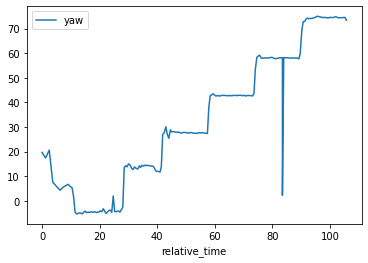

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 3)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

49

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

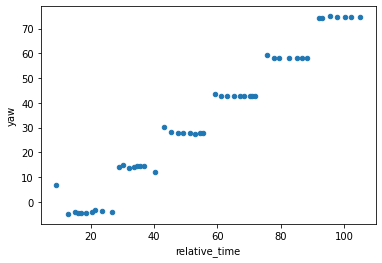

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
7,9.046320,6.741888,0
14,12.966230,-4.847108,0
18,14.974108,-4.126191,0
20,15.956763,-4.558100,0
22,16.941602,-4.385377,0
25,18.399166,-4.442191,0
29,20.304741,-4.005952,0
31,21.249290,-3.167126,0
36,23.711682,-3.707436,0
42,26.619554,-4.075094,0


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
7,9.046320,6.741888,0,-6.741888
14,12.966230,-4.847108,0,4.847108
46,29.069565,14.309370,15,0.690630
48,30.054489,15.058088,15,-0.058088
74,43.007064,30.129746,30,-0.129746
79,45.521690,28.151044,30,1.848956
107,59.362316,43.519986,45,1.480014
111,61.259860,42.764617,45,2.235383
140,75.596424,59.169300,60,0.830700
145,78.045600,58.062465,60,1.937535


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,10.0,3.057269,3.474906,-6.741888,3.782065,4.100643,4.427988,4.847108
15,8.0,0.890248,0.925406,-0.058088,0.512999,0.616517,0.850557,3.010700
30,8.0,1.880274,0.829502,-0.129746,2.014481,2.171049,2.226810,2.449235
45,9.0,2.069749,0.225979,1.480014,2.094099,2.130810,2.149378,2.235383
60,7.0,1.719308,0.400093,0.830700,1.777020,1.850092,1.931011,1.938300
75,7.0,0.481629,0.283298,0.053188,0.346641,0.494298,0.627122,0.876393


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

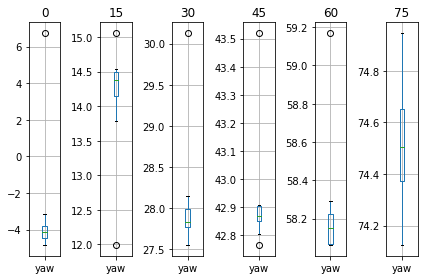

In [16]:
box_plotter(target)

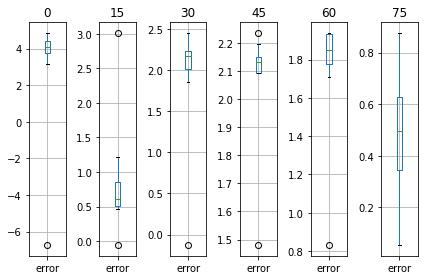

In [17]:
box_plotter('error')